In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('figure', figsize=(10, 6))

In [2]:
def df_bar(df,plotfeature, byfeature, **kwargs):
    df_total = df.groupby(byfeature).size()
    df_by_feature = df.groupby([byfeature, plotfeature]).size()
    df_by_feature.unstack().plot(kind = 'bar', stacked = True, **kwargs)
    return None

In [3]:
def norm_df_bar(df,plotfeature, byfeature, **kwargs):
    df_total = df.groupby(byfeature).size()
    df_by_feature = df.groupby([byfeature, plotfeature]).size()
    df_by_feature_normalized = df_by_feature.div(df_total, level = byfeature)
    df_by_feature_normalized.unstack().plot(kind = 'bar', stacked = True, **kwargs)
    return None

In [2]:
X_train = pd.read_csv('train_values.csv')
y_train = pd.read_csv('train_labels.csv')

In [6]:
X_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [7]:
y_train.groupby('status_group').count()/len(y_train)

,id
status_group,
functional,0.543081
functional needs repair,0.072677
non functional,0.384242


54.3% Functional

7.2% Functional needs repair

38.4% Non-Functional

Let's try to plot the pumps by GPS locations:

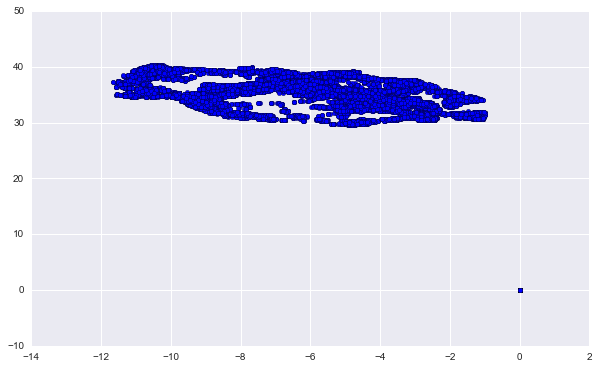

In [7]:
plt.scatter(X_train.latitude,X_train.longitude)

Weird outlier at 0,0 - let's ignore:

(28, 42)

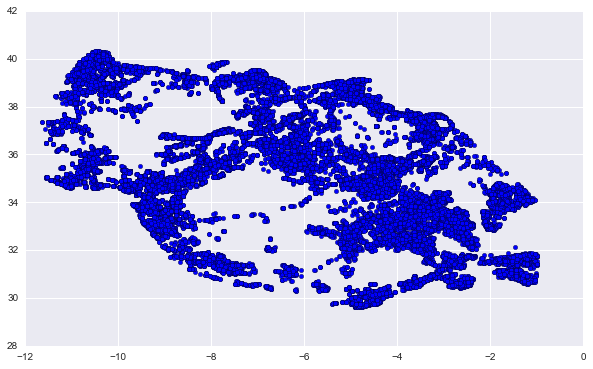

In [8]:
plt.scatter(X_train.latitude,X_train.longitude)
plt.xlim([-12,0])
plt.ylim([28,42])

Now to add the labels:

In [8]:
color_dict = {'functional':'g','non functional':'r','functional needs repair':'b'}
y_train['color_labels'] = y_train.status_group.map(color_dict)

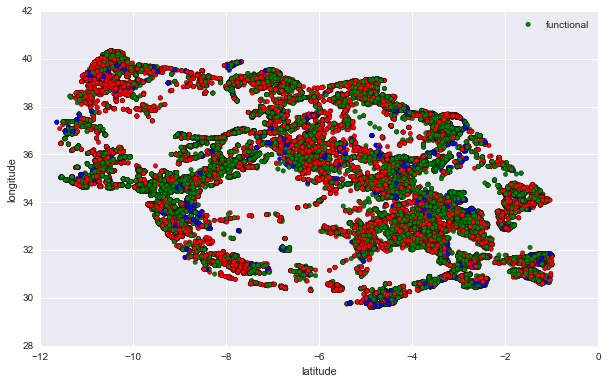

In [10]:
plt.scatter(X_train.latitude,X_train.longitude,c=y_train.color_labels)
plt.xlim([-12,0])
plt.ylim([28,42])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend(['functional','non functional','functional needs repair'])

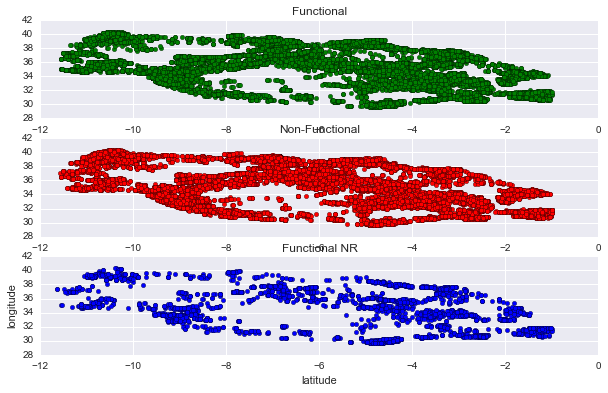

In [11]:
plt.subplot(311)
plt.scatter(X_train.latitude[y_train.status_group=='functional'],X_train.longitude[y_train.status_group=='functional'], label = 'functional', c = 'g')
plt.xlim([-12,0])
plt.ylim([28,42])
plt.title('Functional')
plt.subplot(312)
plt.scatter(X_train.latitude[y_train.status_group=='non functional'],X_train.longitude[y_train.status_group=='non functional'], label = 'non functional', c = 'r')
plt.xlim([-12,0])
plt.ylim([28,42])
plt.title('Non-Functional')
plt.subplot(313)
plt.scatter(X_train.latitude[y_train.status_group=='functional needs repair'],X_train.longitude[y_train.status_group=='functional needs repair'], label = 'functional need repair')
plt.xlim([-12,0])
plt.ylim([28,42])
plt.title('Functional NR')

plt.xlabel('latitude')
plt.ylabel('longitude')

In [12]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib qt
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# nf = X_train[y_train.status_group=='non functional']
# ax.scatter3D(xs = nf.latitude,ys = nf.longitude,zs=nf.gps_height)
# plt.xlim([-12,0])
# plt.ylim([28,42])

At first glance it wouldn't appear like geographical location has much to say about the distribution of functional vs non-functional well. 

We can separate the features to categories:

|Related to Geography|Related to management|Other|
| :-------------: | :-------------: | :-------------: |
|gps_height|date_recorded|amount_tsh|
|longitude|funder|public_meeting|
|latitude|installer|construction_year|
|basin|population|extraction_type|
|subvillage|recorded_by|extraction_type_group|
|region|scheme_management|extraction_type_class|
|region_code|scheme_name|payment|
|district_code|permit|payment_type|
|Iga|management|water_quality|
|ward|management_group | quality_gorup|
|||quantity|
|||quantity_group|
|||source|
|||source_type|
|||source_class|
|||waterpoint_type|
|||waterpoint_type_group|
|||wpt_name|
|||num_private

# A look at public_meeting:

In [13]:
X_train.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [14]:
not_pub = y_train[X_train.public_meeting == False]
not_pub.groupby('status_group').count()/len(not_pub)

,id,color_labels
status_group,,
functional,0.429871,0.429871
functional needs repair,0.087438,0.087438
non functional,0.482690,0.482690


Interesting observation:
**Not being a public meeting place increases the likelihood of a pump not being functional from 38% to 48%. **

# A look at construction_year:

In [9]:
pump_by_year = pd.DataFrame({'year':X_train.construction_year, 'label': y_train.status_group})

In [10]:
(pump_by_year.year==0).sum()/float(len(pump_by_year))

0.34863636363636363

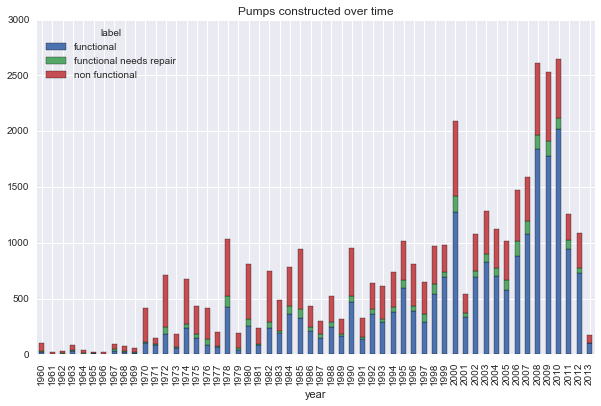

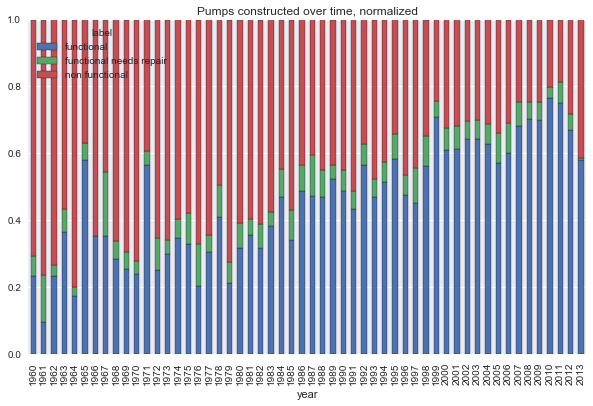

In [11]:
%matplotlib inline
plt.rc('figure', figsize=(10, 6))

df_bar(pump_by_year[pump_by_year.year>0],'label','year', title='Pumps constructed over time')
norm_df_bar(pump_by_year[pump_by_year.year>0],'label','year', title='Pumps constructed over time, normalized')

General conclusions at first glance:

1. Overall increase in construction over time, with significant spikes in 2000, and between 2008-2011.
2. Older pumps are more likely to be nonfunctional - **pumps built before 1987 are more than 50% likely to be non-functional.** 
3. **Important caveat** : About 35% of pumps are not labeled with a contruction year. 

In [22]:
year0 = pump_by_year[pump_by_year.year == 0]
year0.groupby('label').size()/len(year0)

label
functional                 0.509682
functional needs repair    0.086388
non functional             0.403931
dtype: float64

# A look at extraction:

In [18]:
extraction_features = X_train[['extraction_type','extraction_type_group','extraction_type_class']].copy()
extraction_features['labels'] = y_train.status_group
extraction_features['year'] = X_train.construction_year
extraction_features.groupby(['extraction_type_class','extraction_type_group','extraction_type']).size()

extraction_type_class  extraction_type_group  extraction_type          
gravity                gravity                gravity                      26780
handpump               afridev                afridev                       1770
                       india mark ii          india mark ii                 2400
                       india mark iii         india mark iii                  98
                       nira/tanira            nira/tanira                   8154
                       other handpump         other - mkulima/shinyanga        2
                                              other - play pump               85
                                              other - swn 81                 229
                                              walimi                          48
                       swn 80                 swn 80                        3670
motorpump              mono                   mono                          2865
                       other motorpum

In [19]:
extraction_by_label = extraction_features.groupby(['extraction_type_class','extraction_type_group','extraction_type','labels']).size()
extraction_by_label

extraction_type_class  extraction_type_group  extraction_type            labels                 
gravity                gravity                gravity                    functional                 16048
                                                                         functional needs repair     2701
                                                                         non functional              8031
handpump               afridev                afridev                    functional                  1200
                                                                         functional needs repair       42
                                                                         non functional               528
                       india mark ii          india mark ii              functional                  1448
                                                                         functional needs repair       79
                                                       

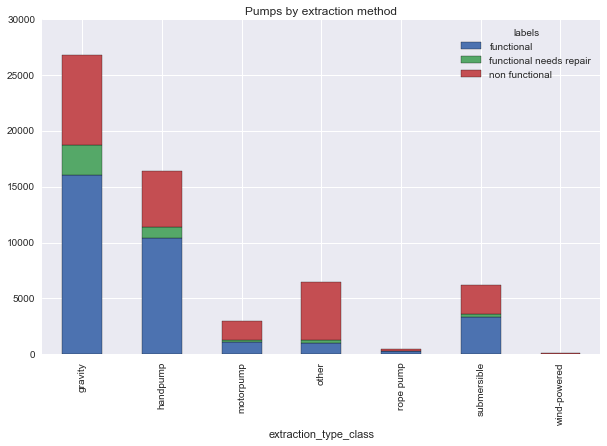

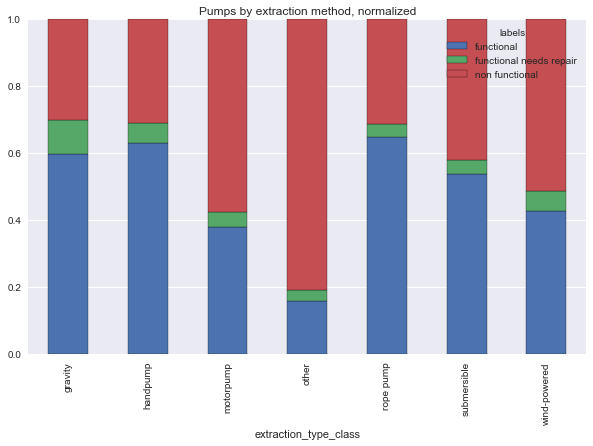

In [20]:
df_bar(extraction_features,'labels','extraction_type_class', title='Pumps by extraction method')
norm_df_bar(extraction_features,'labels','extraction_type_class', title='Pumps by extraction method, normalized')

**General conclusions at first glance:**

1. A significant majority of pumps utilize gravity-based extraction. These pumps appear fairly reliable (>60% function, ~10% need repair.
2. Motopump-based pumps appear unreliable, with only ~40% functioning. However, these represent a very small portion of overall pumps. 
3. Pumps utilizing "other" forms of extraction are the most unreliable category, with only 20% functioning. 
4. Overall, extraction type seems like a promising predictive feature.
5. **Caveat** : These conclusions are based solely on the 'extraction_type_class' feature. Some classes allow further drill-down into the specific extraction types, which may provide further insights. 

Afterthought: It might be interesting to see how installations have changed over time:

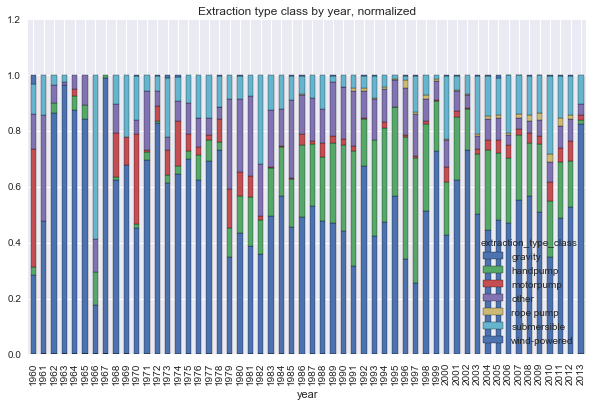

In [21]:
norm_df_bar(extraction_features[extraction_features.year>0],'extraction_type_class','year', title = 'Extraction type class by year, normalized')

# A look at payment:

In [22]:
payment = X_train[['payment','payment_type']].copy()
payment.groupby(['payment','payment_type']).size()

payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64

'payment' feature seems redundant.

In [23]:
payment = pd.DataFrame({'payment' : X_train.payment_type, 'labels' : y_train.status_group})
payment.groupby('payment').size()/len(payment)

payment
annually      0.061313
monthly       0.139731
never pay     0.426734
on failure    0.065892
other         0.017744
per bucket    0.151263
unknown       0.137323
dtype: float64

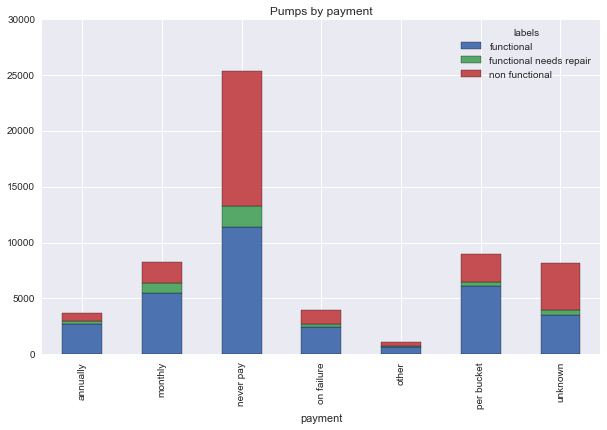

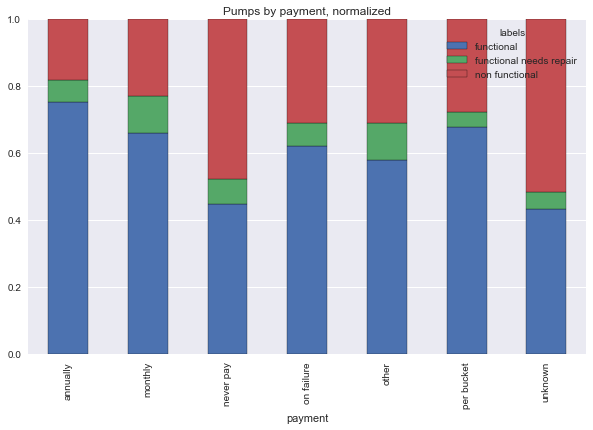

In [24]:
df_bar(payment,'labels','payment', title='Pumps by payment')
norm_df_bar(payment,'labels','payment', title='Pumps by payment, normalized')

1. 42% of pumps are categorized as 'never pay', of which about 50% are non-functional
2. Payment should probably be categorized as a management-related feature.

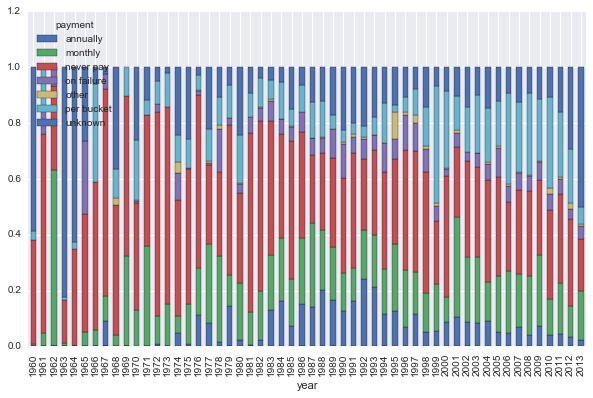

In [25]:
payment['year'] = X_train.construction_year
norm_df_bar(payment[payment.year>0],'payment', 'year')

# A look at quality


In [26]:
quality = X_train[['water_quality','quality_group']].copy()
quality['labels'] = y_train.status_group
quality['year'] = X_train.construction_year

In [109]:
quality.groupby(['quality_group','water_quality']).size()

quality_group  water_quality     
colored        coloured                490
fluoride       fluoride                200
               fluoride abandoned       17
good           soft                  50818
milky          milky                   804
salty          salty                  4856
               salty abandoned         339
unknown        unknown                1876
dtype: int64

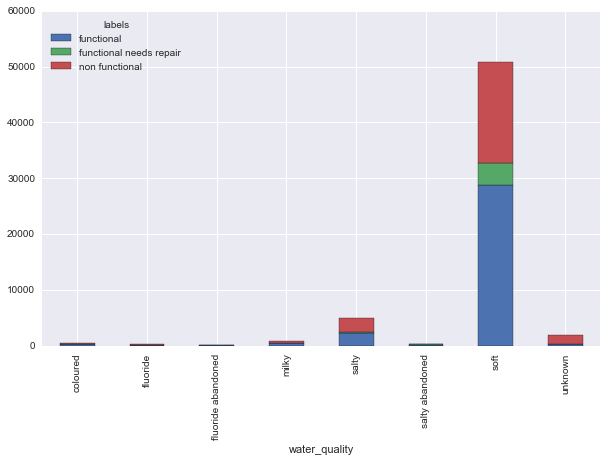

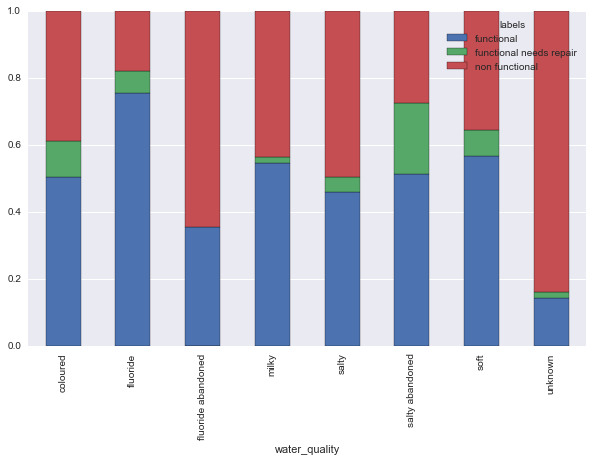

In [27]:
df_bar(quality,'labels','water_quality')
norm_df_bar(quality,'labels','water_quality')

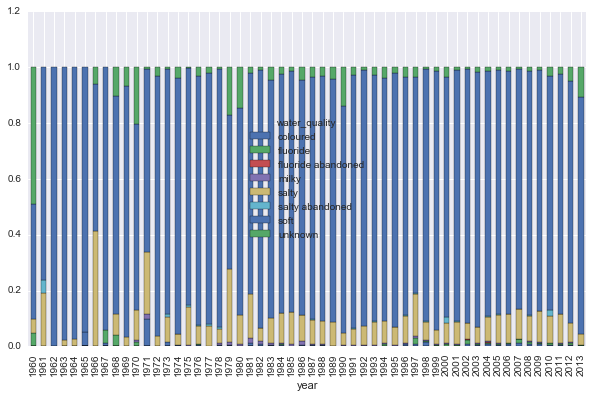

In [28]:
a = norm_df_bar(quality[quality.year>0],'water_quality','year')
# , title = 'water quality by year, normalized'


# A look at quantity

In [29]:
quantity = X_train[['quantity','quantity_group']].copy()
quantity['year'] = X_train.construction_year
quantity['labels'] = y_train.status_group

quantity.groupby(['quantity_group','quantity']).size()

quantity_group  quantity    
dry             dry              6246
enough          enough          33186
insufficient    insufficient    15129
seasonal        seasonal         4050
unknown         unknown           789
dtype: int64

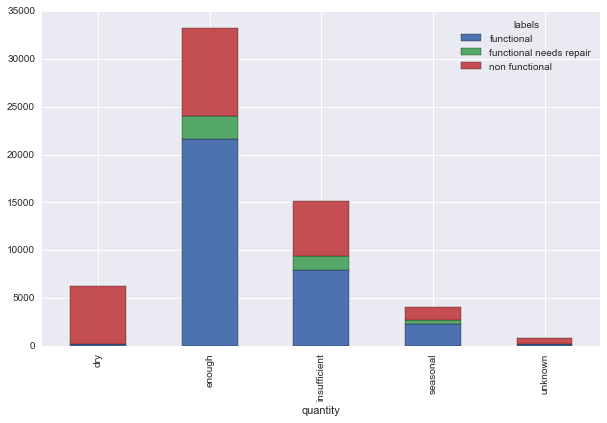

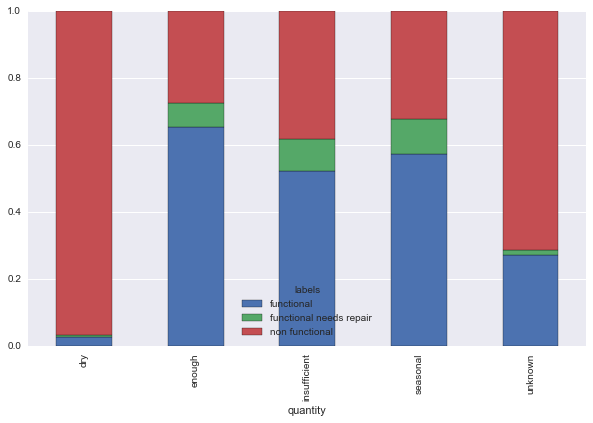

In [30]:
df_bar(quantity, 'labels','quantity')
norm_df_bar(quantity, 'labels','quantity')

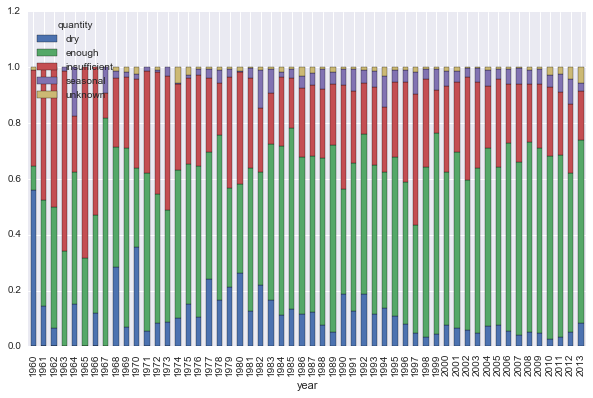

In [31]:
norm_df_bar(quantity[quantity.year>0],'quantity', 'year')

# A look at source

In [32]:
source = X_train[['source','source_type','source_class']].copy()
source['year'] = X_train.construction_year
source['labels'] = y_train.status_group

In [33]:
source.groupby(['source_class','source_type','source']).size()

source_class  source_type           source              
groundwater   borehole              hand dtw                  874
                                    machine dbh             11075
              shallow well          shallow well            16824
              spring                spring                  17021
surface       dam                   dam                       656
              rainwater harvesting  rainwater harvesting     2295
              river/lake            lake                      765
                                    river                    9612
unknown       other                 other                     212
                                    unknown                    66
dtype: int64

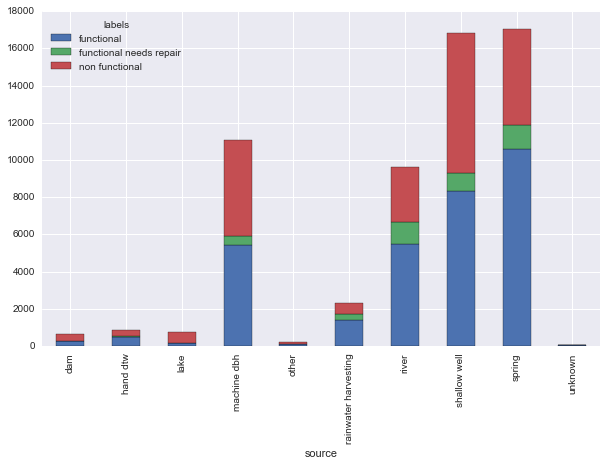

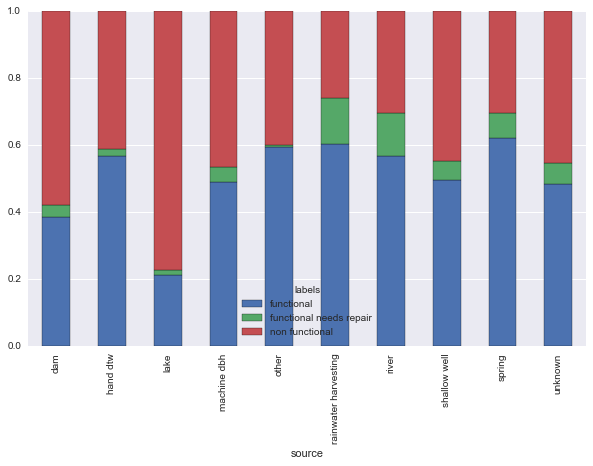

In [111]:
df_bar(source,'labels','source')
norm_df_bar(source,'labels','source')

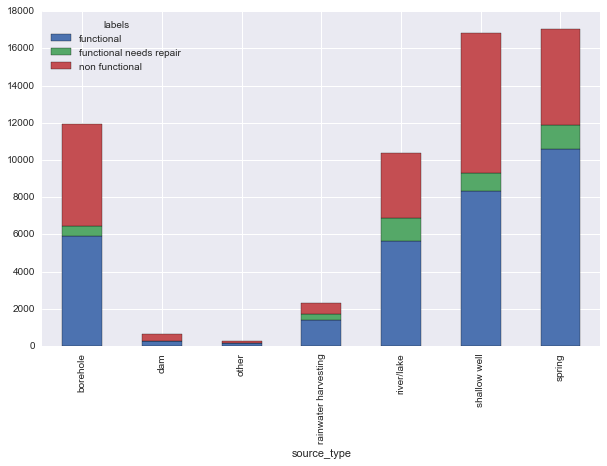

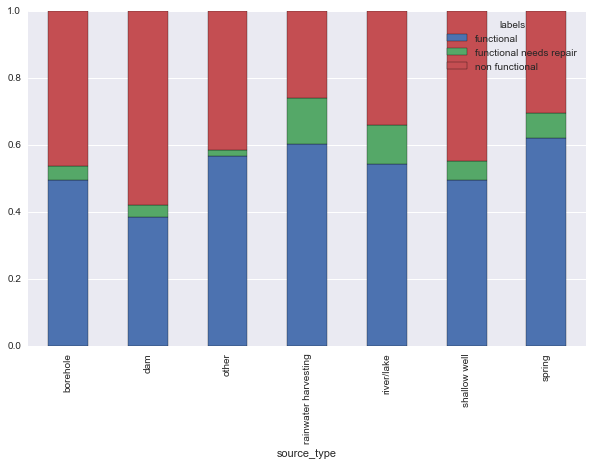

In [35]:
df_bar(source,'labels','source_type')
norm_df_bar(source,'labels','source_type')

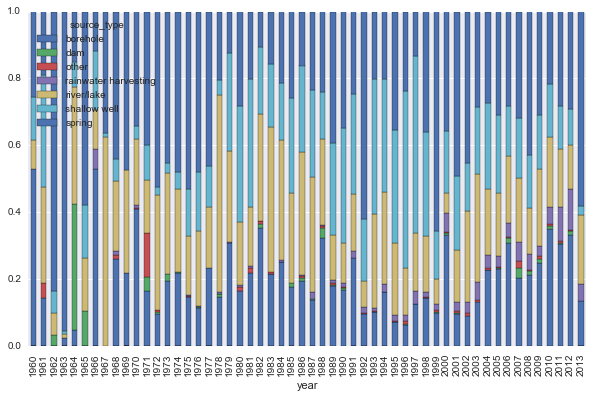

In [36]:
norm_df_bar(source[source.year>0],'source_type','year')

# A look at waterpoint type

In [37]:
wpt = X_train[['waterpoint_type','waterpoint_type_group']].copy()
wpt['year'] = X_train.construction_year
wpt['labels'] = y_train.status_group

In [38]:
wpt.groupby(['waterpoint_type_group','waterpoint_type', 'labels']).size()

waterpoint_type_group  waterpoint_type              labels                 
cattle trough          cattle trough                functional                    84
                                                    functional needs repair        2
                                                    non functional                30
communal standpipe     communal standpipe           functional                 17726
                                                    functional needs repair     2260
                                                    non functional              8536
                       communal standpipe multiple  functional                  2235
                                                    functional needs repair      648
                                                    non functional              3220
dam                    dam                          functional                     6
                                                    non functional        

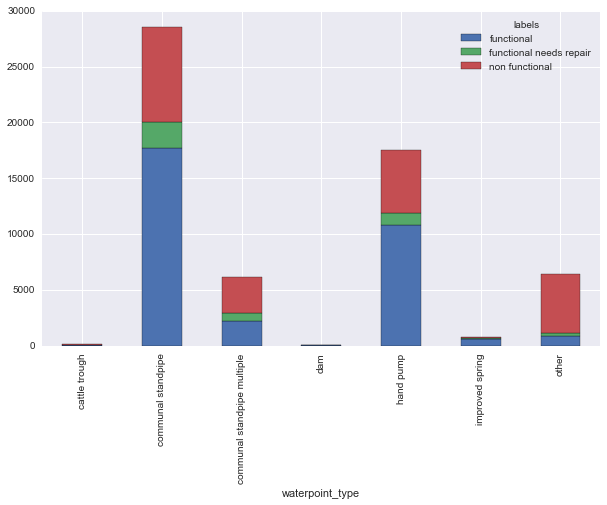

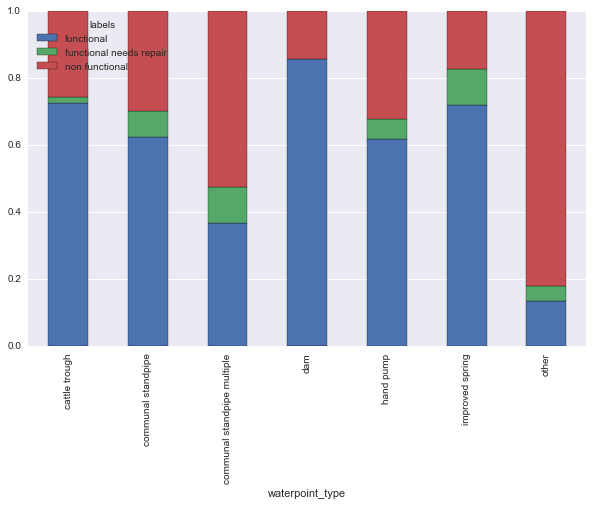

In [39]:
df_bar(wpt,'labels','waterpoint_type')
norm_df_bar(wpt,'labels','waterpoint_type')

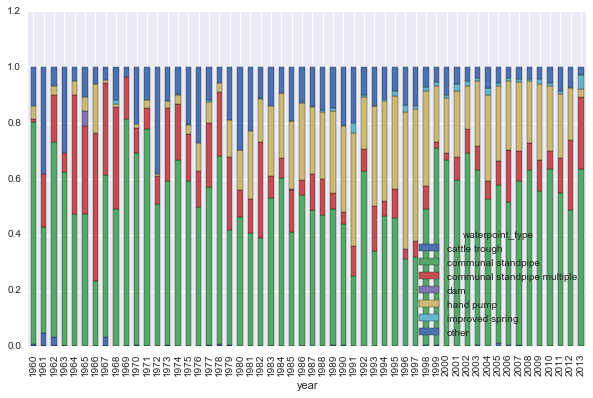

In [40]:
norm_df_bar(wpt[wpt.year>0],'waterpoint_type','year')

# A look at date_recorded:

In [41]:
bydate = X_train[['date_recorded']].copy()
bydate['year'] = X_train.construction_year
bydate['labels'] = y_train.status_group

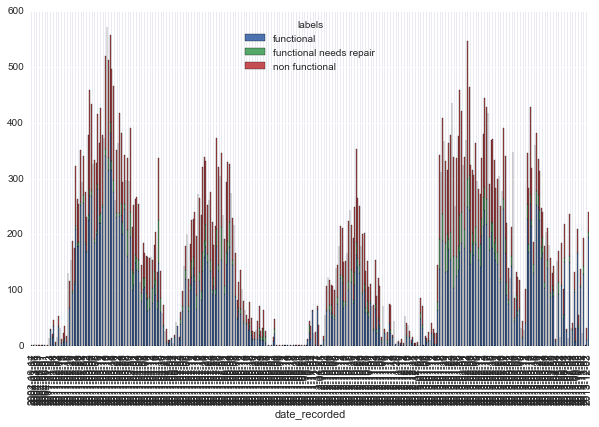

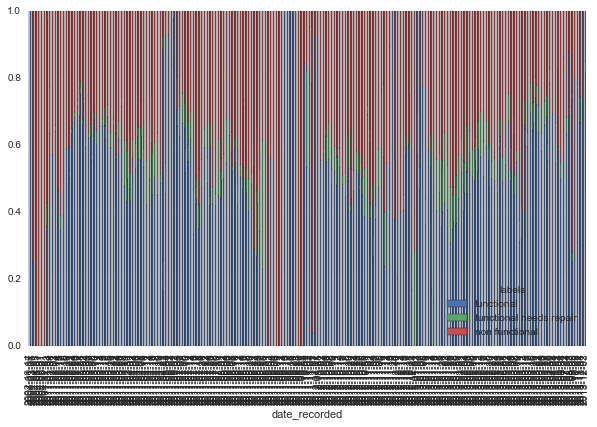

In [42]:
df_bar(bydate,'labels','date_recorded')
norm_df_bar(bydate,'labels','date_recorded')

# A look at funder

In [43]:
funder = X_train[['funder']].copy()
funder['labels'] = y_train.status_group
funder['year'] = X_train.construction_year
# df_bar(funder,'labels','funder')
# norm_df_bar(funder,'labels','funder')


In [74]:
by_funder_sorted = funder.groupby(['funder','labels']).size().sort_values(ascending=False)
by_funder_sorted

funder                        labels                 
Government Of Tanzania        non functional             4663
                              functional                 3720
Danida                        functional                 1713
                              non functional             1242
Hesawa                        non functional             1034
                              functional                  936
Rwssp                         functional                  805
World Vision                  functional                  743
Kkkt                          functional                  723
World Bank                    non functional              707
Government Of Tanzania        functional needs repair     701
Private Individual            functional                  690
Unicef                        functional                  600
World Bank                    functional                  545
Germany Republi               functional                  538
Kkkt            

# A look at installer

In [96]:
installer = pd.DataFrame({'installer':X_train.installer,'year':X_train.construction_year,'labels':y_train.status_group})
top10 = installer.groupby(['installer']).size().sort_values(ascending=False).head(10)
top10_labels = installer.groupby(['installer','labels']).size().sort_values(ascending=False).head(10)
top10_labels_norm = top10_labels.div(top10, level = 'installer')
top10_labels

installer   labels                 
DWE         functional                 9433
            non functional             6347
            functional needs repair    1622
Government  non functional             1034
RWE         non functional              765
Commu       functional                  724
DANIDA      functional                  542
CES         functional                  538
Government  functional                  535
Hesawa      functional                  475
dtype: int64

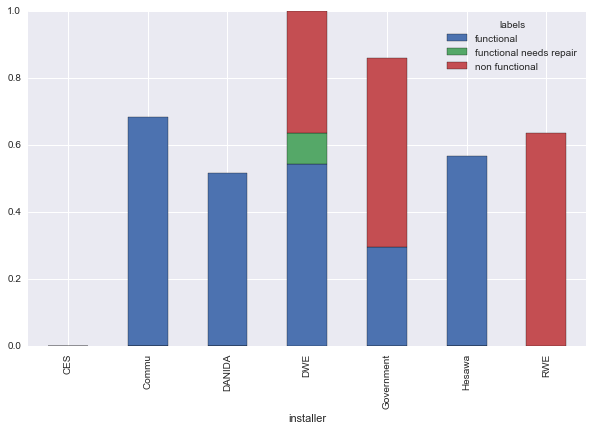

In [92]:
top10_labels_norm.unstack().plot(kind = 'bar', stacked = True)

In [86]:
num_installers = len(installer.groupby(['installer']).size().sort_values(ascending=False))
num_installers

2145

# A look at population

In [101]:
population = pd.DataFrame({'population':X_train.population,'year':X_train.construction_year,'labels':y_train.status_group})

population.sort_values('population',ascending=False).head(20)

,labels,population,year
30537,functional,30500,2008
14308,functional needs repair,15300,1983
51398,functional,11463,2006
56742,functional,10000,2006
30231,functional,10000,1992
31363,functional,10000,2006
12784,non functional,9865,2010
13725,functional needs repair,9500,2010
31473,non functional,9000,2008
51919,non functional,9000,2010


# A look at recorded_by

# A look at scheme

In [107]:
scheme = pd.DataFrame({'scheme':X_train.scheme_name,'scheme_mgmt':X_train.scheme_management,'year':X_train.construction_year,'labels':y_train.status_group})
scheme.groupby(['scheme','labels']).size()

scheme                       labels                 
14 Kambarage                 functional                   7
A                            functional                  23
                             functional needs repair      2
                             non functional              17
ADP                          functional                   6
                             non functional               3
ADP Simbo                    functional                  15
                             non functional              10
ADP Simbu                    non functional               1
ADRA                         functional                   7
                             non functional               1
AIC                          functional                   1
AIC kahunda                  functional                   1
AMREF                        non functional               3
AMRSF                        non functional               1
AUWASA Pipe scheme           functional        

# A look at permit

# A look at management

In [5]:
scheme = pd.DataFrame({'mgmt':X_train.management,'mgmt_grp':X_train.management_group,'year':X_train.construction_year,'labels':y_train.status_group})
scheme.groupby(['mgmt_grp','mgmt','labels']).size()

mgmt_grp    mgmt              labels                 
commercial  company           functional                   267
                              functional needs repair       15
                              non functional               403
            private operator  functional                  1476
                              functional needs repair       44
                              non functional               451
            trust             functional                    46
                              functional needs repair        6
                              non functional                26
            water authority   functional                   446
                              functional needs repair       52
                              non functional               406
other       other             functional                   505
                              functional needs repair       55
                              non functional               284
 

# GPS height:

In [3]:
gpsh = pd.DataFrame({'gpsh':X_train.gps_height,'labels':y_train.status_group})

In [10]:
gpsh['gpsh'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gpsh, dtype: float64

In [15]:
gpsh['cents'] = [np.round(height,-2) for height in gpsh['gpsh']]

In [17]:
gpsh.head()

,gpsh,labels,cents
0,1390,functional,1400
1,1399,functional,1400
2,686,functional,700
3,263,non functional,300
4,0,functional,0


In [22]:
gpsh.loc[gpsh['gpsh']==0]['labels'].value_counts()

functional                 10469
non functional              8206
functional needs repair     1763
Name: labels, dtype: int64